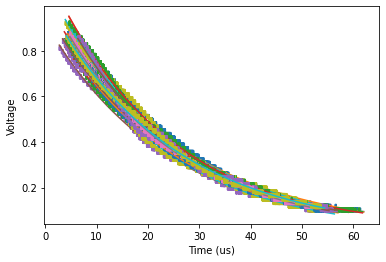

In [6]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import glob
%matplotlib inline

def objective(x,a,b):
    return a*np.power(b,x)

data_path = '20211104-0002/'
data_files = glob.glob(data_path + '*.csv')
ring_downs = []

for i in data_files:
    data = pd.read_csv(i, skiprows=1) 
    start_full = data.loc[(data['(V)'] == max(data['(V)']))].last_valid_index()
    end_full = data.loc[(data['(V)']== 0) & (data['(us)'] >= 0)].first_valid_index()
    
    data2 = data[start_full:end_full]
    
    #need to do 0.9 and 0.1 times the voltage and find the times for those
    
    start = data2.loc[(data2['(V)'] <= max(data2['(V)'])*0.9)].first_valid_index()
    end = data2.loc[(data2['(V)'] <= max(data2['(V)'])*0.1)].first_valid_index()

    time = data['(us)']
    time = time[start:end]
    voltage = data['(V)']
    voltage = voltage[start:end]
    
    popt, pcov = curve_fit(objective, time, voltage)
    
    residuals = voltage - objective(time, *popt)
    res_ss = np.sum(residuals**2)
    ss_tot = np.sum((voltage - np.mean(voltage))**2)
    r_squared = 1 - (res_ss / ss_tot)
    #print(r_squared)

    ringdown = max(time) - min(time)
    ring_downs.append(ringdown)
    
    plt.plot(time, voltage)
    plt.plot(time, objective(time, *popt))
    plt.xlabel('Time (us)')
    plt.ylabel('Voltage')


In [7]:
print(np.mean(ring_downs))
print(np.std(ring_downs))

51.299098549500016
2.808897175520869
